In [79]:
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(tidymodels)
options(repr.matrix.max.rows = 6)

<h2>Methods & Results</h2>

<h4>Data Wrangling</h4>

In [19]:
players <- read_csv("https://raw.githubusercontent.com/Kqvii/DSCI100-Group13/refs/heads/main/data/players.csv") |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(!is.na(Age), !is.na(played_hours), !is.na(subscribe))
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


In [81]:
players_wrangled <- players |> select(subscribe, played_hours, Age)

subscribe,subscribed,average_hours_played
<fct>,<int>,<dbl>
FALSE,52,0.5019231
TRUE,142,7.8830986


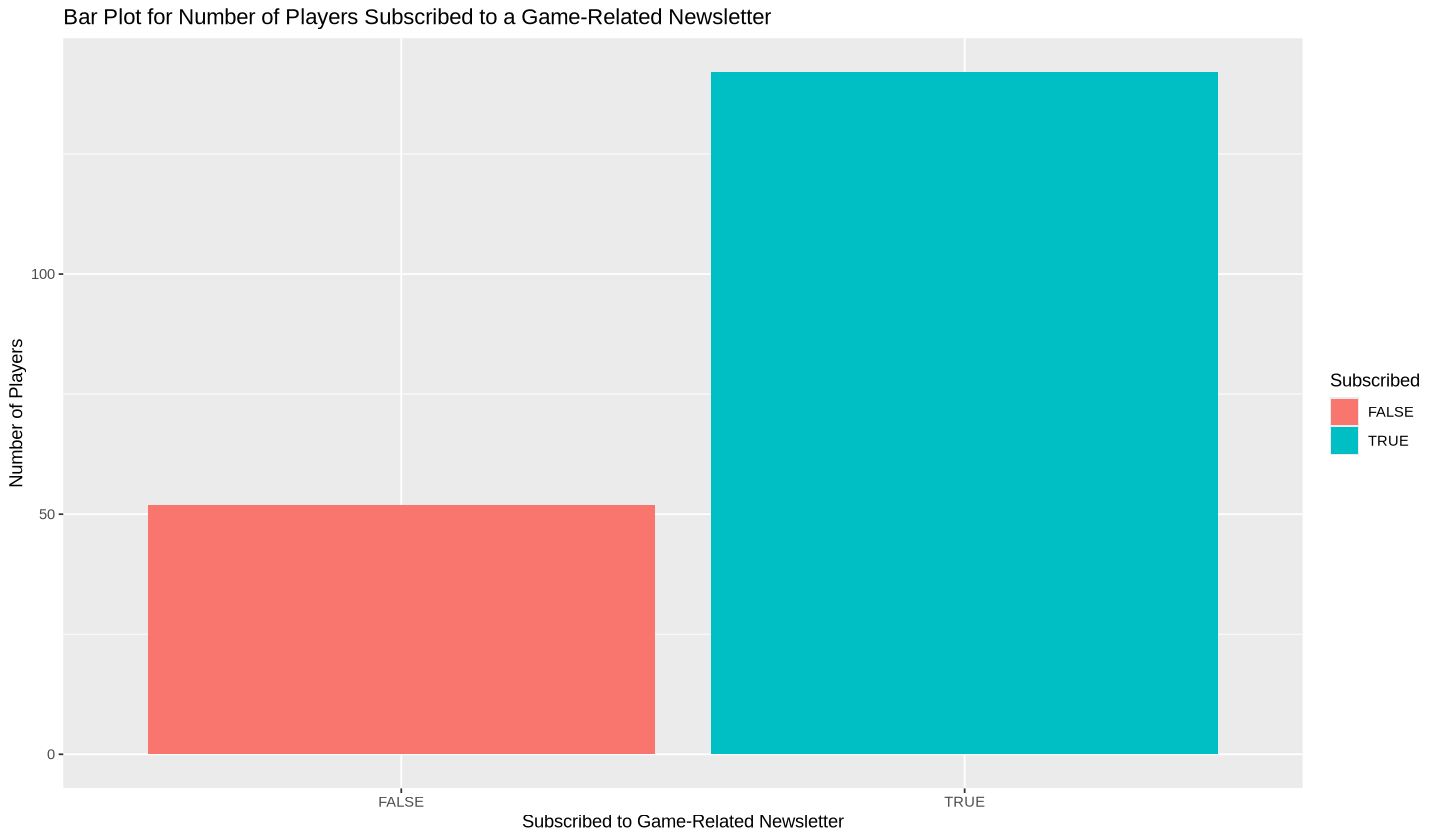

In [82]:
subscribed_viz_data <- players_wrangled |>
    group_by(subscribe) |>
    summarize(subscribed = n(),
              average_hours_played = mean(played_hours))
subscribed_viz_data

subscribed_viz <- subscribed_viz_data |>
    ggplot(aes(x = subscribe, y = subscribed, fill = subscribe)) +
        geom_bar(stat = "identity") +
        labs(x = "Subscribed to Game-Related Newsletter",
             y = "Number of Players",
             title = "Bar Plot for Number of Players Subscribed to a Game-Related Newsletter",
             fill = "Subscribed")
subscribed_viz

In [83]:
players_split <- initial_split(players_wrangled, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)
players_train
players_test

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
FALSE,0.0,17
FALSE,0.0,22
FALSE,0.1,17
⋮,⋮,⋮
TRUE,0,17
TRUE,0,20
TRUE,0,17


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,0.0,17
FALSE,0.0,21
TRUE,0.1,17
⋮,⋮,⋮
TRUE,0.8,22
TRUE,32.0,22
TRUE,0.1,44


In [84]:
subscribe_recipe <- recipe(subscribe ~ played_hours + Age, data = players_wrangled) |>
  step_center(all_predictors()) |>  
  step_scale(all_predictors())

subscribe_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
      set_engine("kknn") |>
      set_mode("classification")

subscribe_fit <- workflow() |>
      add_recipe(subscribe_recipe) |>
      add_model(subscribe_model) |>
      fit(data = players_train)

In [85]:
players_predictions <- predict(subscribe_fit, players_test)
players_test_predictions <- bind_cols(players_test, players_predictions)

players_test_predictions

subscribe,played_hours,Age,.pred_class
<fct>,<dbl>,<dbl>,<fct>
TRUE,0.0,17,FALSE
FALSE,0.0,21,TRUE
TRUE,0.1,17,FALSE
⋮,⋮,⋮,⋮
TRUE,0.8,22,TRUE
TRUE,32.0,22,TRUE
TRUE,0.1,44,FALSE


In [86]:
players_test
players_predictions

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,0.0,17
FALSE,0.0,21
TRUE,0.1,17
⋮,⋮,⋮
TRUE,0.8,22
TRUE,32.0,22
TRUE,0.1,44


.pred_class
<fct>
FALSE
TRUE
FALSE
⋮
TRUE
TRUE
FALSE


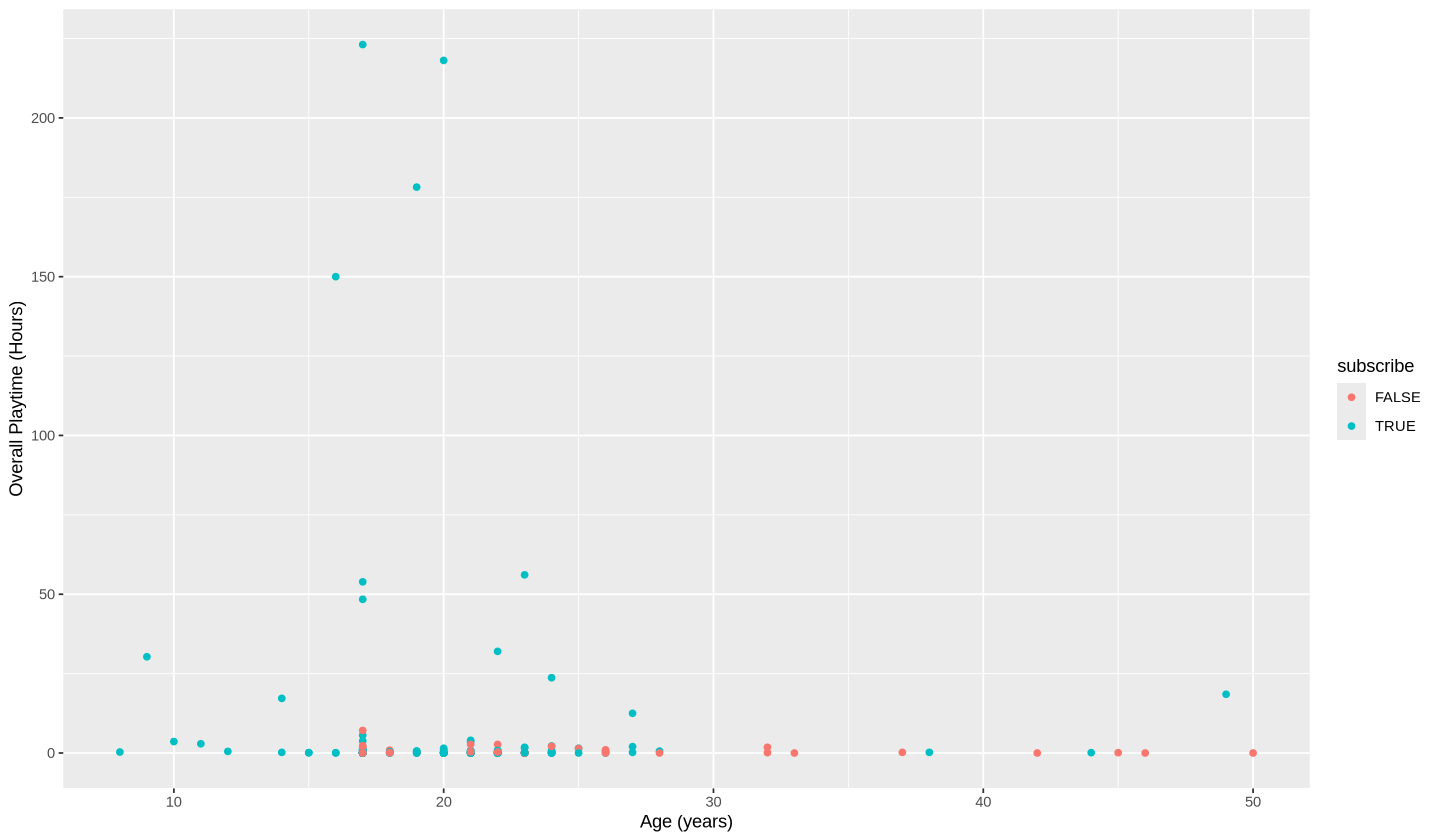

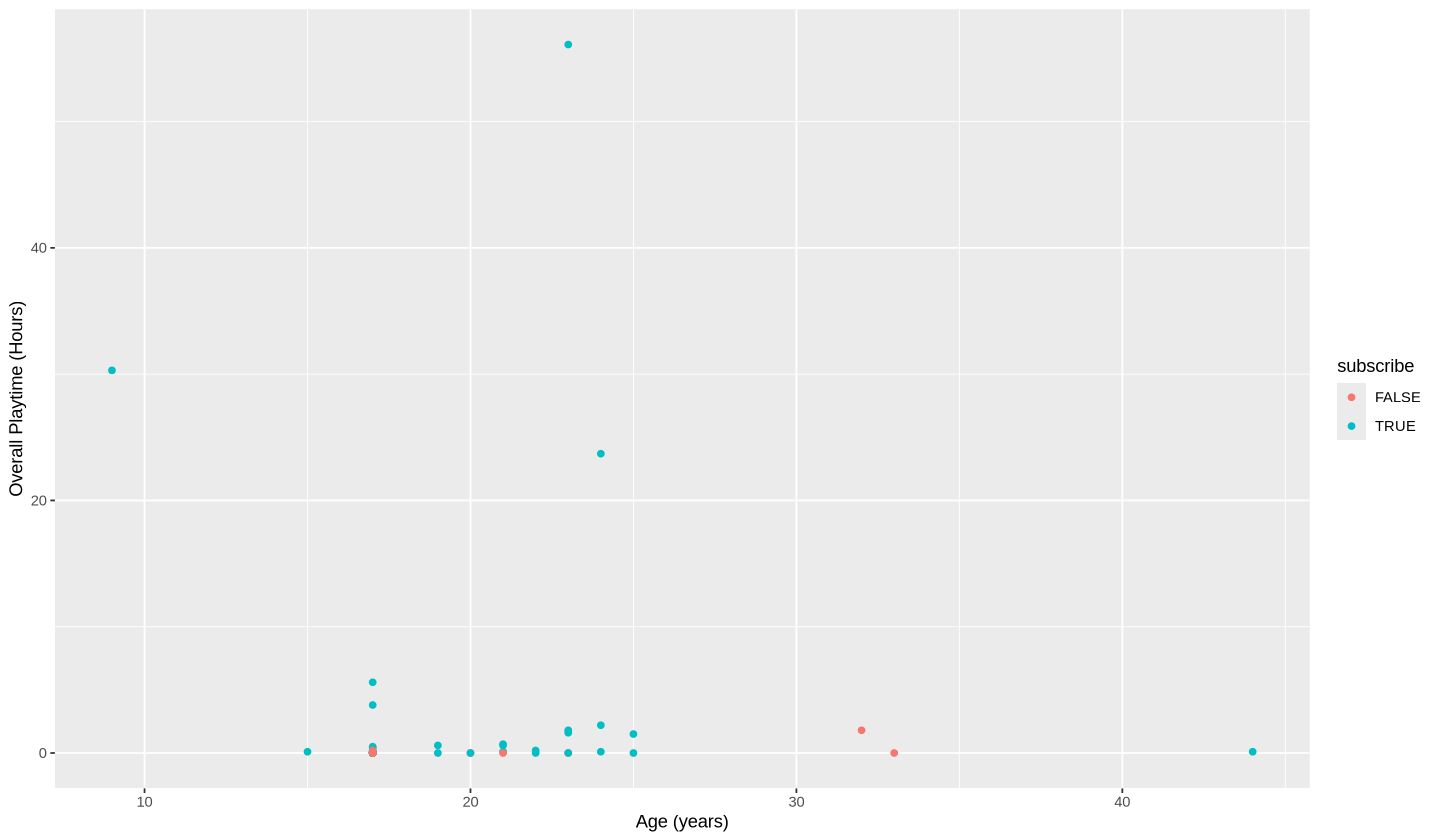

In [76]:
players_plot <- players_wrangled |>
    ggplot(aes(x = Age, y = played_hours)) + 
        geom_point(aes(colour = subscribe)) +
        xlab("Age (years)") + 
        ylab("Overall Playtime (Hours)")
players_plot


players_prediction_plot <- players_test_predictions |>
    ggplot(aes(x = Age, y = played_hours)) + 
        geom_point(aes(colour = subscribe)) +
        xlab("Age (years)") + 
        ylab("Overall Playtime (Hours)")
players_prediction_plot

Warning message:
“Removed 10 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


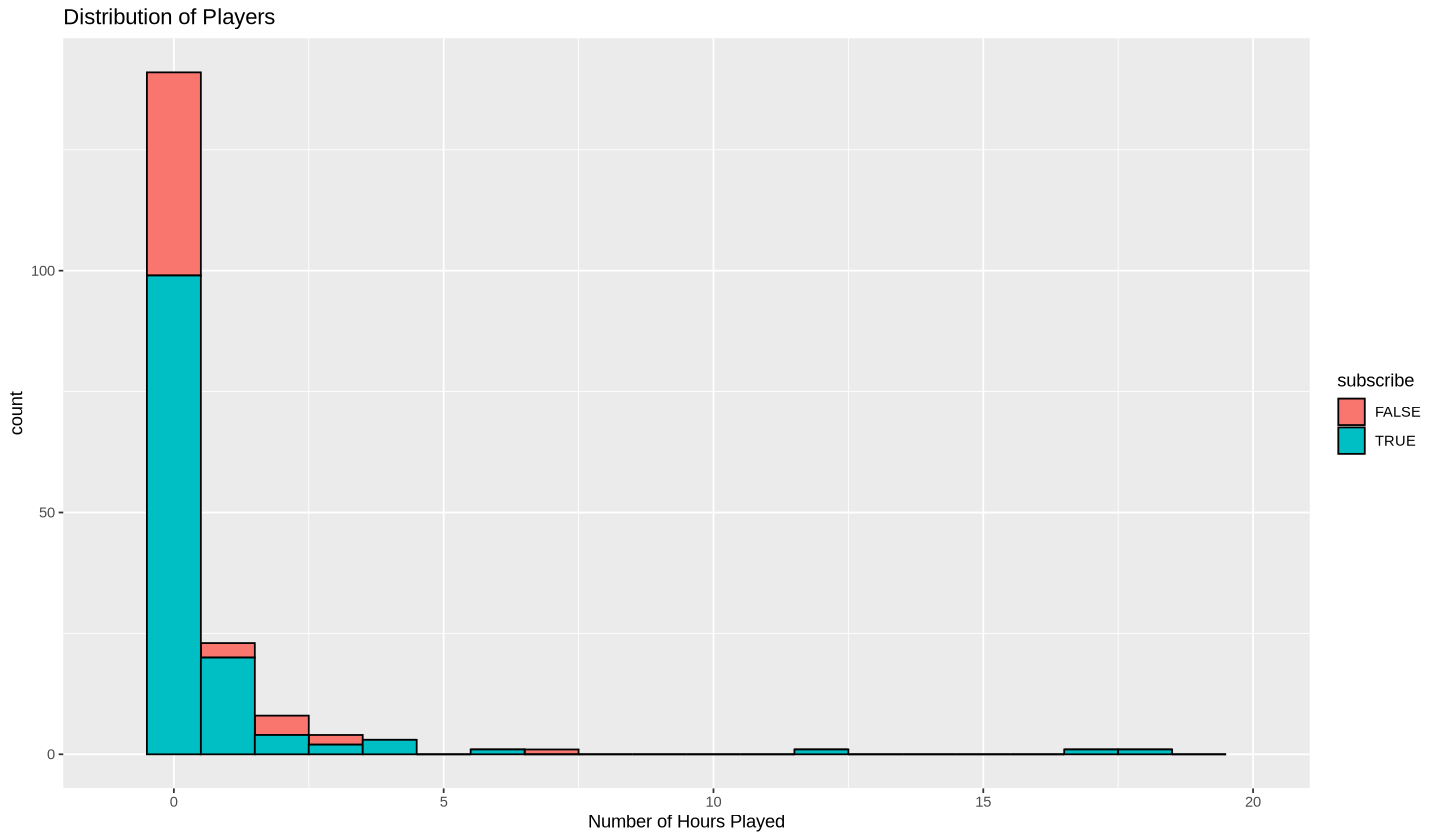

In [77]:
options(repr.plot.width=12)
players_dist <- players_wrangled |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram(binwidth = 1, color = "Black") +
    scale_x_continuous(limits = c(-1, 20)) +
    labs(x = "Number of Hours Played", title = "Distribution of Players")

players_dist

In [78]:
new_obs <- tibble(played_hours = 0.1,Age =40)
class_prediction <- predict(subscribe_fit, new_obs)
class_prediction

.pred_class
<fct>
FALSE


In [34]:
subscribe_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

In [35]:
players_resample_fit <- workflow() |> 
  add_recipe(subscribe_recipe) |>   
  add_model(subscribe_model) |>       
  fit_resamples(resamples = subscribe_vfold)

In [36]:
players_metrics <- collect_metrics(players_resample_fit)
players_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6197701,5,0.03728357,Preprocessor1_Model1
roc_auc,binary,0.5133349,5,0.04874309,Preprocessor1_Model1


In [37]:
players_tune <- nearest_neighbor(mode = "classification", 
                             neighbors = tune(), 
                             weight_func = "rectangular") |> 
  set_engine("kknn")

players_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [38]:
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |> 
  add_recipe(subscribe_recipe) |>  # Add preprocessing recipe
  add_model(players_tune) |>       # Add k-NN model with tuning
  tune_grid(resamples = subscribe_vfold, grid = k_vals) |>  # Perform tuning on cross-validation splits
  collect_metrics()  # Aggregate performance metrics
                 
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5108210,5,0.04892711,Preprocessor1_Model01
1,roc_auc,binary,0.5508117,5,0.04688763,Preprocessor1_Model01
2,accuracy,binary,0.5108210,5,0.04892711,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,binary,0.4778873,5,0.05449860,Preprocessor1_Model09
10,accuracy,binary,0.5579146,5,0.05311715,Preprocessor1_Model10
10,roc_auc,binary,0.4596088,5,0.05003170,Preprocessor1_Model10


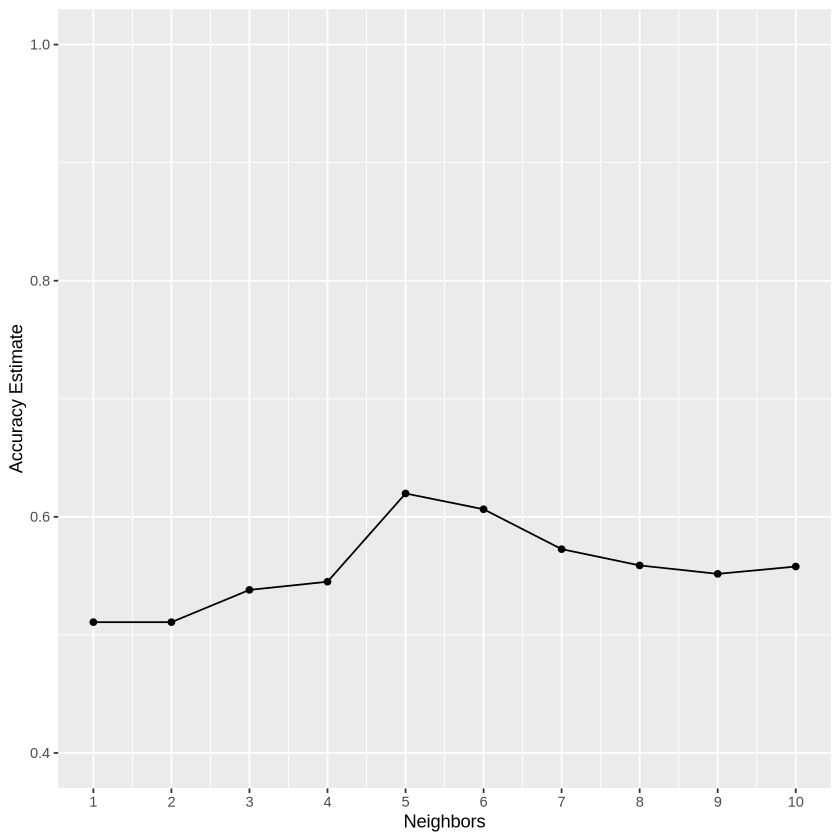

In [39]:
accuracies <- knn_results |> filter(.metric == "accuracy")
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k